In [2]:
from services.main_service import get_coin_data
from services.lstm_service import get_evaluations, train_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.utils import timeseries_dataset_from_array
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import math
from keras.callbacks import EarlyStopping

SELECTED_COINS = ["ADA-GBP", "BAT-GBP", "BCH-GBP", "BNB-GBP"]

In [2]:
coin_data_df = get_coin_data(SELECTED_COINS)
# coin_data_df = coin_data_df.iloc[] # select last year data
selected_coin = "ADA-GBP"



Using the cached dataset..


In [3]:
dataset = coin_data_df[[selected_coin]]
dataset.index = pd.to_datetime(dataset.index)
dataset = dataset.iloc[-365:]

len(dataset)

365

In [4]:
test_size =  int(math.floor(len(dataset) * (20 / 100)))
test_size

73

In [5]:
# train = dataset.iloc[:-test_size]
# test = dataset.iloc[-test_size:]

# scaler = MinMaxScaler()
# scaler.fit(train.values.reshape(-1, 1))

# scaled_train = scaler.transform(train.values.reshape(-1, 1))
# scaled_test = scaler.transform(test.values.reshape(-1, 1))

In [5]:
scaler = MinMaxScaler()
scaled_dataset = scaler.fit_transform(dataset)

sequence_length = 10
num_features = len(dataset.columns)

sequences = []
labels = []

for i in range(len(scaled_dataset) - sequence_length):
    seq = scaled_dataset[i:i+sequence_length]
    label = scaled_dataset[i+sequence_length][0]
    sequences.append(seq)
    labels.append(label)

sequences = np.array(sequences)
labels = np.array(labels)

train_size = int(0.8 * len(sequences))
train_x, test_x = sequences[:train_size], sequences[train_size:]
train_y, test_y = labels[:train_size], labels[train_size:]




(292,)

In [6]:
# n_input = 7
# n_features = 1

# timeseries_dataset = timeseries_dataset_from_array(scaled_train, scaled_train, sequence_length=n_input, batch_size=1)

In [6]:
model = Sequential()
model.add(LSTM(128, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\nisha\anaconda3\envs\com724\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# model.fit(timeseries_dataset, epochs=60)
history = model.fit(
    train_x, train_y,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0028 - val_loss: 0.0200
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0026 - val_loss: 0.0201
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0024 - val_loss: 0.0153
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0027 - val_loss: 0.0195
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0025 - val_loss: 0.0216
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0023 - val_loss: 0.0173
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0022 - val_loss: 0.0168
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0024 - val_loss: 0.0175
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0022 - val_loss: 0.0157
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0026 - val_loss: 0.0164
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0023 - val_loss: 0.0186
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0022 - val_lo

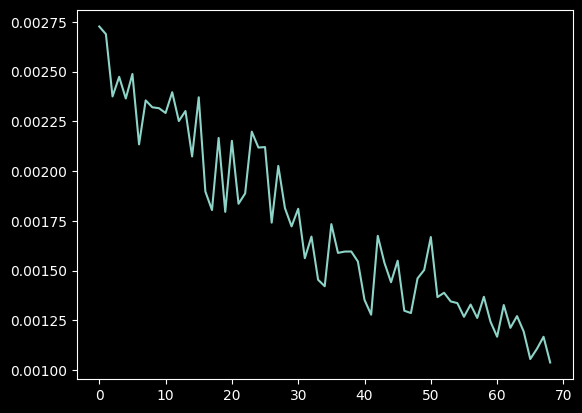

In [10]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

In [10]:
# test_predictions = []

# first_eval_batch = scaled_train[-n_input:]
# current_batch = first_eval_batch.reshape((1, n_input, n_features))

# current_pred = model.predict(current_batch)[0]
# print([[current_pred]])
# print(current_batch)
# print(current_batch[:,1:,:])

# np.append(current_batch[:,1:,:], [[current_pred]], axis=1)


In [11]:
first_eval_batch = scaled_train[-n_input:]
first_eval_batch.reshape((1, n_input, n_features))

array([[[0.78565622],
        [0.70730034],
        [0.7120109 ],
        [0.65810058],
        [0.6651724 ],
        [0.6907506 ],
        [0.66629003]]])

In [12]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

In [13]:
test_predictions

[array([0.7832694], dtype=float32),
 array([0.7005002], dtype=float32),
 array([0.7068628], dtype=float32),
 array([0.6570826], dtype=float32),
 array([0.6702461], dtype=float32),
 array([0.6895815], dtype=float32),
 array([0.67872566], dtype=float32),
 array([0.77912056], dtype=float32),
 array([0.69429743], dtype=float32),
 array([0.7023707], dtype=float32),
 array([0.65703565], dtype=float32),
 array([0.6747212], dtype=float32),
 array([0.6895037], dtype=float32),
 array([0.6893821], dtype=float32),
 array([0.7735328], dtype=float32),
 array([0.6887861], dtype=float32),
 array([0.69854116], dtype=float32),
 array([0.657746], dtype=float32),
 array([0.6787198], dtype=float32),
 array([0.6902546], dtype=float32),
 array([0.6983117], dtype=float32),
 array([0.76682895], dtype=float32),
 array([0.68402624], dtype=float32),
 array([0.6953524], dtype=float32),
 array([0.65903825], dtype=float32),
 array([0.6823323], dtype=float32),
 array([0.69159514], dtype=float32),
 array([0.7055778], 

In [14]:
true_prediction = scaler.inverse_transform(test_predictions)

In [15]:
test_df = pd.DataFrame({
    "Actual": test.values,
    "Prediction": true_prediction.reshape(1, -1)[0].tolist()
}, index=test.index)

In [16]:
test_df

,Actual,Prediction
Date,,
2024-01-19,0.394823,0.454767
2024-01-20,0.396057,0.427146
2024-01-21,0.405388,0.429269
2024-01-22,0.396164,0.412656
2024-01-23,0.376585,0.417049
...,...,...
2024-03-27,0.526641,0.427657
2024-03-28,0.513986,0.433594
2024-03-29,0.515634,0.431141


<Axes: xlabel='Date'>

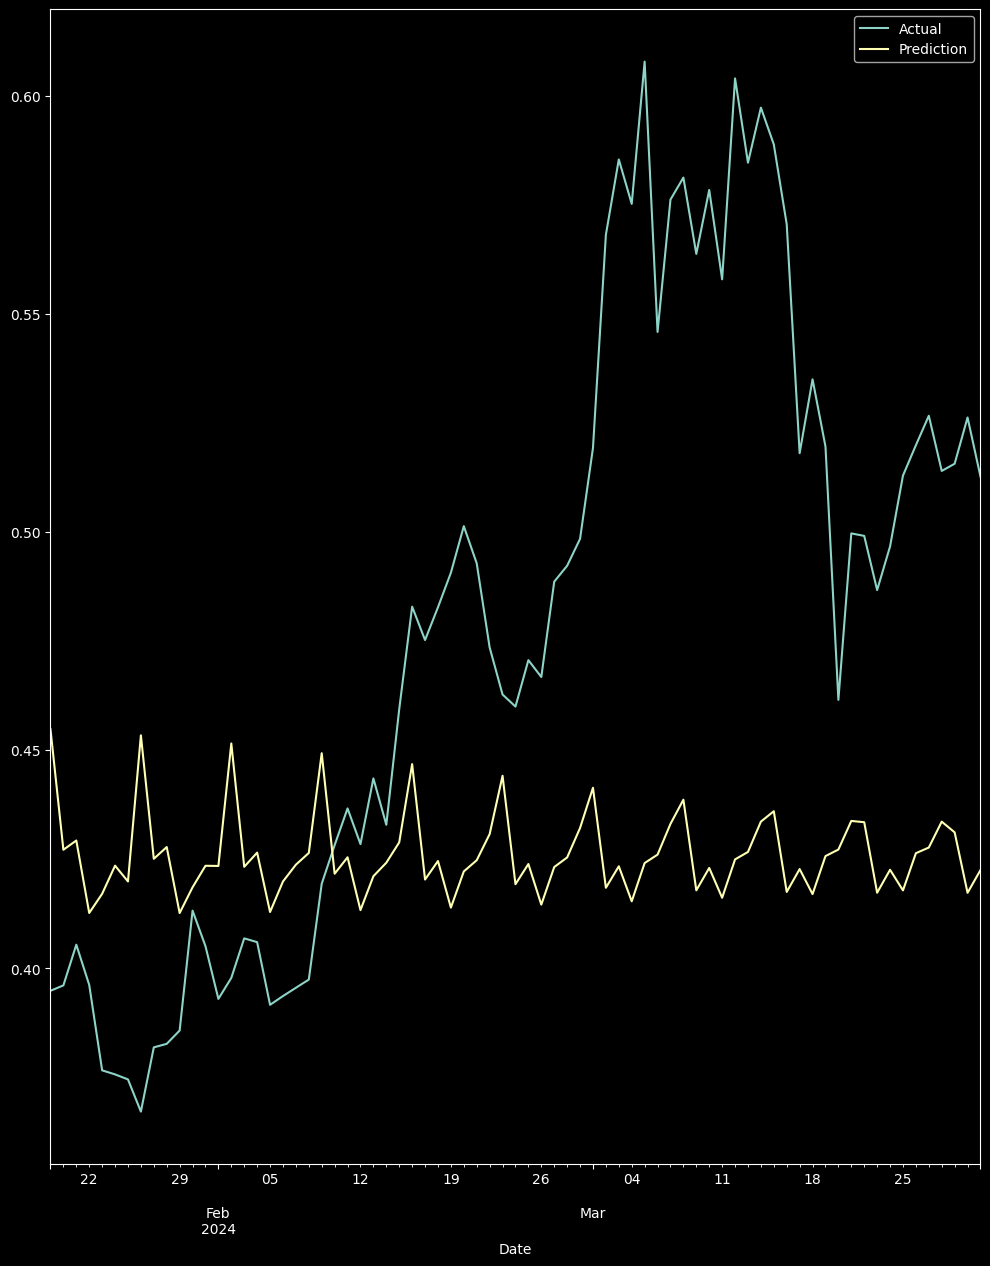

In [17]:
test_df.plot(figsize=(12, 15))

In [15]:
test_y_copies = np.repeat(test_y.reshape(-1, 1), test_x.shape[-1], axis=1)
true_temp = scaler.inverse_transform(test_y_copies)[:,0]

prediction = model.predict(test_x)
# prediction_copies = np.repeat(prediction, 9, axis=-1)
prediction_temp = scaler.inverse_transform(prediction)[:,0]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


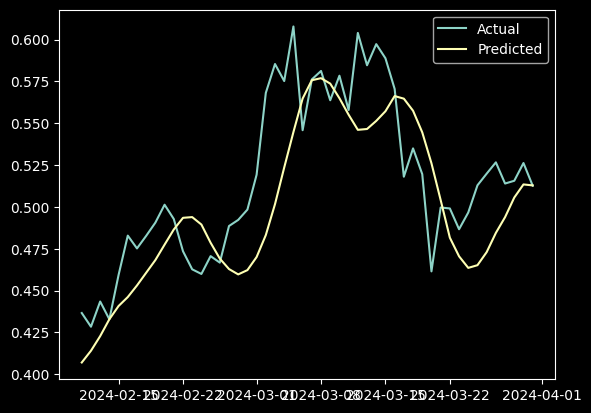

In [16]:
plt.figure(figure=(10,6))
plt.plot(dataset.index[-50:], true_temp[-50:], label='Actual')
plt.plot(dataset.index[-50:], prediction_temp[-50:], label='Predicted')
plt.legend()
plt.show()

In [3]:
df1 = pd.DataFrame(

    {

        "A": ["A0", "A1", "A2", "A3"],

        "B": ["B0", "B1", "B2", "B3"],

        "C": ["C0", "C1", "C2", "C3"],

        "D": ["D0", "D1", "D2", "D3"],

    },

    index=[0, 1, 2, 3],

)

df2 = pd.DataFrame(

    {

        "A": ["A4", "A5", "A6", "A7"],

        "B": ["B4", "B5", "B6", "B7"],

        "C": ["C4", "C5", "C6", "C7"],

        "D": ["D4", "D5", "D6", "D7"],

    },

    index=[4, 5, 6, 7],

)

In [6]:
df1.index.union(df2.index)

Index([0, 1, 2, 3, 4, 5, 6, 7], dtype='int64')